In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import root_mean_squared_error

In [6]:
def rmse(y_true, y_pred):
    mean_squared_error = np.mean((y_true - y_pred) ** 2)  # Среднее значение квадратов ошибок
    return np.sqrt(mean_squared_error)

In [7]:
data = pd.read_feather("wide_data.feather")

X = data.loc[:, ~data.columns.isin(["HL_1", "HL_2", "HL_3", "HL_4", "HL_5", "HL_6", "id"])]
y = data.loc[:, "HL_1":"HL_6"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
mor_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=500, random_state=42)).fit(X_train, y_train)

y_pred = mor_model.predict(X_test)
print(f"Root Mean Squared Error: {rmse(y_test, y_pred)}")

Root Mean Squared Error: 2.1941610460671366


Root Mean Squared Error: 2.1939639438160112 для n_est=1000
Root Mean Squared Error: 2.2284464935263317 для n_est=100
Root Mean Squared Error: 2.1941610460671366 для n_est=500

In [43]:
chain_model = RegressorChain(RandomForestRegressor(n_estimators=1000, random_state=42)).fit(X_train, y_train)

y_pred = chain_model.predict(X_test)
print(f"Root Mean Squared Error: {rmse(y_test, y_pred)}")

Root Mean Squared Error: 2.225661252258286


In [ ]:
lr_model1 = MultiOutputRegressor(LinearRegression()).fit(X_train, y_train)
lr_model2 = RegressorChain(LinearRegression()).fit(X_train, y_train)

y_pred1 = lr_model1.predict(X_test)
print(f"Root Mean Squared Error: {rmse(y_test, y_pred1)}")

y_pred2 = lr_model2.predict(X_test)
print(f"Root Mean Squared Error: {rmse(y_test, y_pred2)}")

Root Mean Squared Error: 2.3543859767245854
Root Mean Squared Error: 2.354385976724586


In [46]:
from sklearn.svm import SVR

svr_model1 = RegressorChain(SVR(kernel='linear')).fit(X_train, y_train)
svr_model2 = RegressorChain(SVR(kernel='poly')).fit(X_train, y_train)
svr_model3 = RegressorChain(SVR(kernel='rbf')).fit(X_train, y_train)

y_pred1 = svr_model1.predict(X_test)
y_pred2 = svr_model2.predict(X_test)
y_pred3 = svr_model3.predict(X_test)

print(f"Root Mean Squared Error: {rmse(y_test, y_pred1)}")
print(f"Root Mean Squared Error: {rmse(y_test, y_pred2)}")
print(f"Root Mean Squared Error: {rmse(y_test, y_pred3)}")

Root Mean Squared Error: 2.4056842024969742
Root Mean Squared Error: 2.2901924434243894
Root Mean Squared Error: 2.2700014717772112


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = RegressorChain(KNeighborsRegressor(n_neighbors=5)).fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
print(f"Root Mean Squared Error: {rmse(y_test, y_pred)}")

Root Mean Squared Error: 2.420055095791554


In [76]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [56]:
tf_model = Sequential([
    Dense(128, input_dim=55, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(6)
])

tf_model.compile(optimizer='adam', loss='mse')
    
history = tf_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

y_pred = tf_model.predict(X_test)
print(f"Root Mean Squared Error: {rmse(y_test, y_pred)}")

Root Mean Squared Error: 2.423056427748568


In [71]:
import matplotlib.pyplot as plt

def plot_nn_losses(hist):
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return(None)

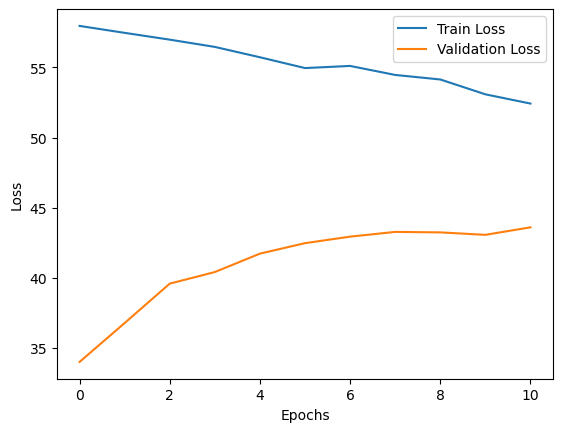

In [106]:
plot_nn_losses(history)

Более сложная модель с промежуточными слоями

In [107]:
def create_model():
    model = models.Sequential([
        layers.Input(shape=(55,)),  # Входной слой для 55 признаков
        
        # Нормализация входных данных
        layers.experimental.preprocessing.Normalization(axis=-1),
        
        # Скрытые слои с регуляризацией
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Выходной слой с 6 нейронами (для 6 целевых признаков)
        layers.Dense(6)
    ])
    
    return model

In [108]:
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Используем MSE как функцию потерь
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

# Оценка модели
test_results = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest MSE: {test_results[0]:.2f}, Test RMSE: {test_results[1]:.2f}")



Test MSE: 6.32, Test RMSE: 2.32


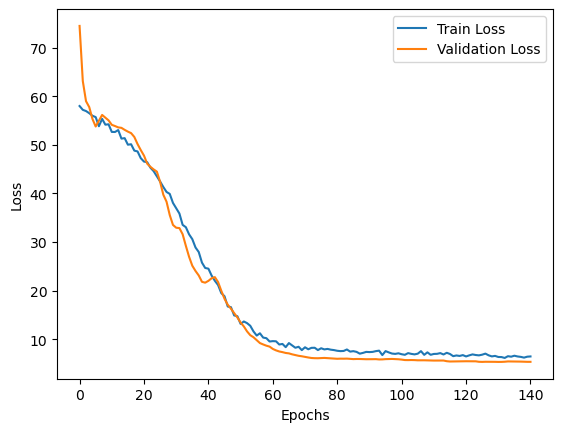

In [109]:
plot_nn_losses(history)

In [8]:
from tabpfn import TabPFNRegressor

tab_model = RegressorChain(TabPFNRegressor()).fit(X_train, y_train)

y_pred = tab_model.predict(X_test)
print(f"Root Mean Squared Error: {rmse(y_test, y_pred)}")

d:\Programs\anaconda3\Lib\site-packages\tabpfn\base.py:100: UserWarning: Downloading model to C:\Users\egorg\AppData\Roaming\tabpfn\tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Root Mean Squared Error: 2.217128435102972


tabpfn (обучался почти 9 минут) - rmse 2.217